# 环境配置与数据加载

In [1]:
# 基础数据处理库
import pandas as pd
import numpy as np

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示（解决图表中文乱码问题）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('..\penguins_size.csv')

# 查看数据基本信息：前5行、数据维度、字段类型
print("数据集前5行：")
print(df.head())
print("\n数据集维度（行×列）：", df.shape)
print("\n字段类型与非空值统计：")
print(df.info())

数据集前5行：
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  

数据集维度（行×列）： (344, 7)

字段类型与非空值统计：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    fl

# 数据预处理
## 统计并处理缺失值、异常值

In [2]:
# 步骤1：统计缺失值（按字段展示）
missing_info = df.isnull().sum()
missing_ratio = (missing_info / len(df)) * 100  # 计算缺失比例（%）
missing_df = pd.DataFrame({
    '缺失值数量': missing_info,
    '缺失比例(%)': missing_ratio.round(2)
})
print("缺失值统计：")
print(missing_df[missing_df['缺失值数量'] > 0])

# 步骤2：处理缺失值（因缺失占比低，直接删除）
df_clean = df.dropna()  # 删除含空值的行
print(f"\n删除缺失值后数据量：{df_clean.shape[0]} 行")

# 步骤3：识别并修正异常值（如sex字段的"."）
print("\nsex字段唯一值：", df_clean['sex'].unique())
df_clean = df_clean[df_clean['sex'] != '.']  # 过滤异常值"."
print(f"修正sex异常值后数据量：{df_clean.shape[0]} 行")

缺失值统计：
                   缺失值数量  缺失比例(%)
culmen_length_mm       2     0.58
culmen_depth_mm        2     0.58
flipper_length_mm      2     0.58
body_mass_g            2     0.58
sex                   10     2.91

删除缺失值后数据量：334 行

sex字段唯一值： ['MALE' 'FEMALE' '.']
修正sex异常值后数据量：333 行


## 创建衍生特征

In [3]:
# 复制原始数据列，基于副本创建衍生特征
df_clean['culmen_ratio'] = df_clean['culmen_length_mm'] / df_clean['culmen_depth_mm']  # 喙长/喙深比率

# 验证衍生特征（查看前3行）
print("\n衍生特征示例：")
print(df_clean[['culmen_length_mm', 'culmen_depth_mm', 'culmen_ratio', 'body_mass_g']].head(3))


衍生特征示例：
   culmen_length_mm  culmen_depth_mm  culmen_ratio  body_mass_g
0              39.1             18.7      2.090909       3750.0
1              39.5             17.4      2.270115       3800.0
2              40.3             18.0      2.238889       3250.0


## 特征标准化与分类特征编码

In [4]:
# 步骤1：分离数值特征和分类特征
numeric_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'culmen_ratio']
category_cols = ['species', 'island', 'sex']

# 步骤2：数值特征标准化（Z-Score，均值0，标准差1）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# 步骤3：分类特征编码（标签编码，适合后续建模）
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in category_cols:
    le = LabelEncoder()
    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])
    label_encoders[col] = le  # 保存编码器，便于后续反向解析

# 验证编码结果
print("\n分类特征编码示例（species/island/sex）：")
print(df_clean[['species', 'species_encoded', 'island', 'island_encoded', 'sex', 'sex_encoded']].head(3))
# 保存为新文件，避免覆盖原始数据
df_clean.to_csv('..\penguins_eda_processed.csv', index=False)
print("\n预处理完成！已保存为 penguins_eda_processed.csv")


分类特征编码示例（species/island/sex）：
  species  species_encoded     island  island_encoded     sex  sex_encoded
0  Adelie                0  Torgersen               2    MALE            1
1  Adelie                0  Torgersen               2  FEMALE            0
2  Adelie                0  Torgersen               2  FEMALE            0

预处理完成！已保存为 penguins_eda_processed.csv


# 可视化分析

## 单变量分布分析

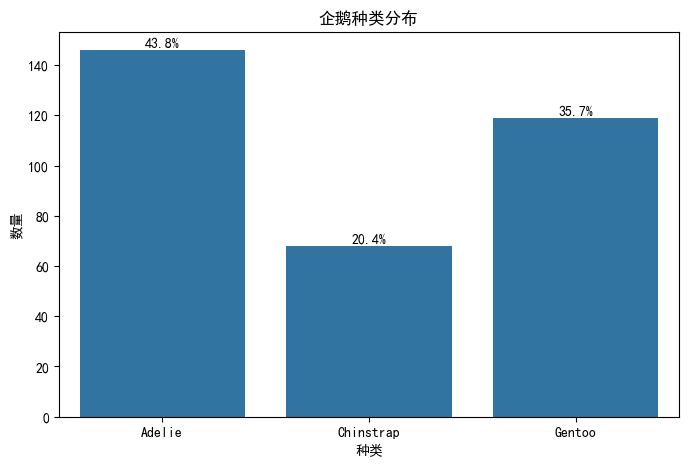

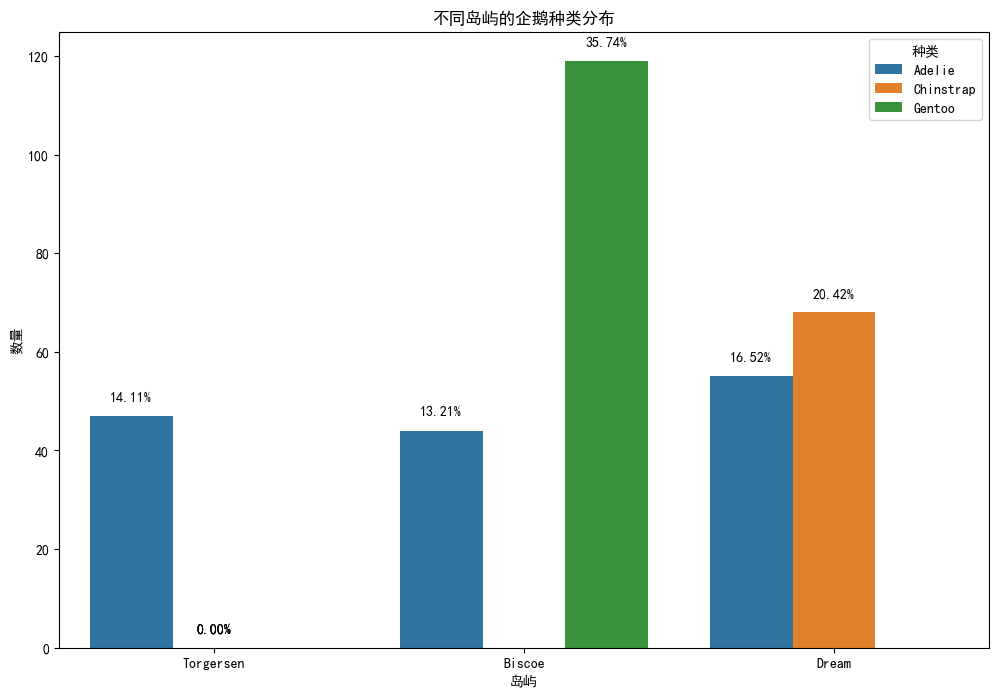

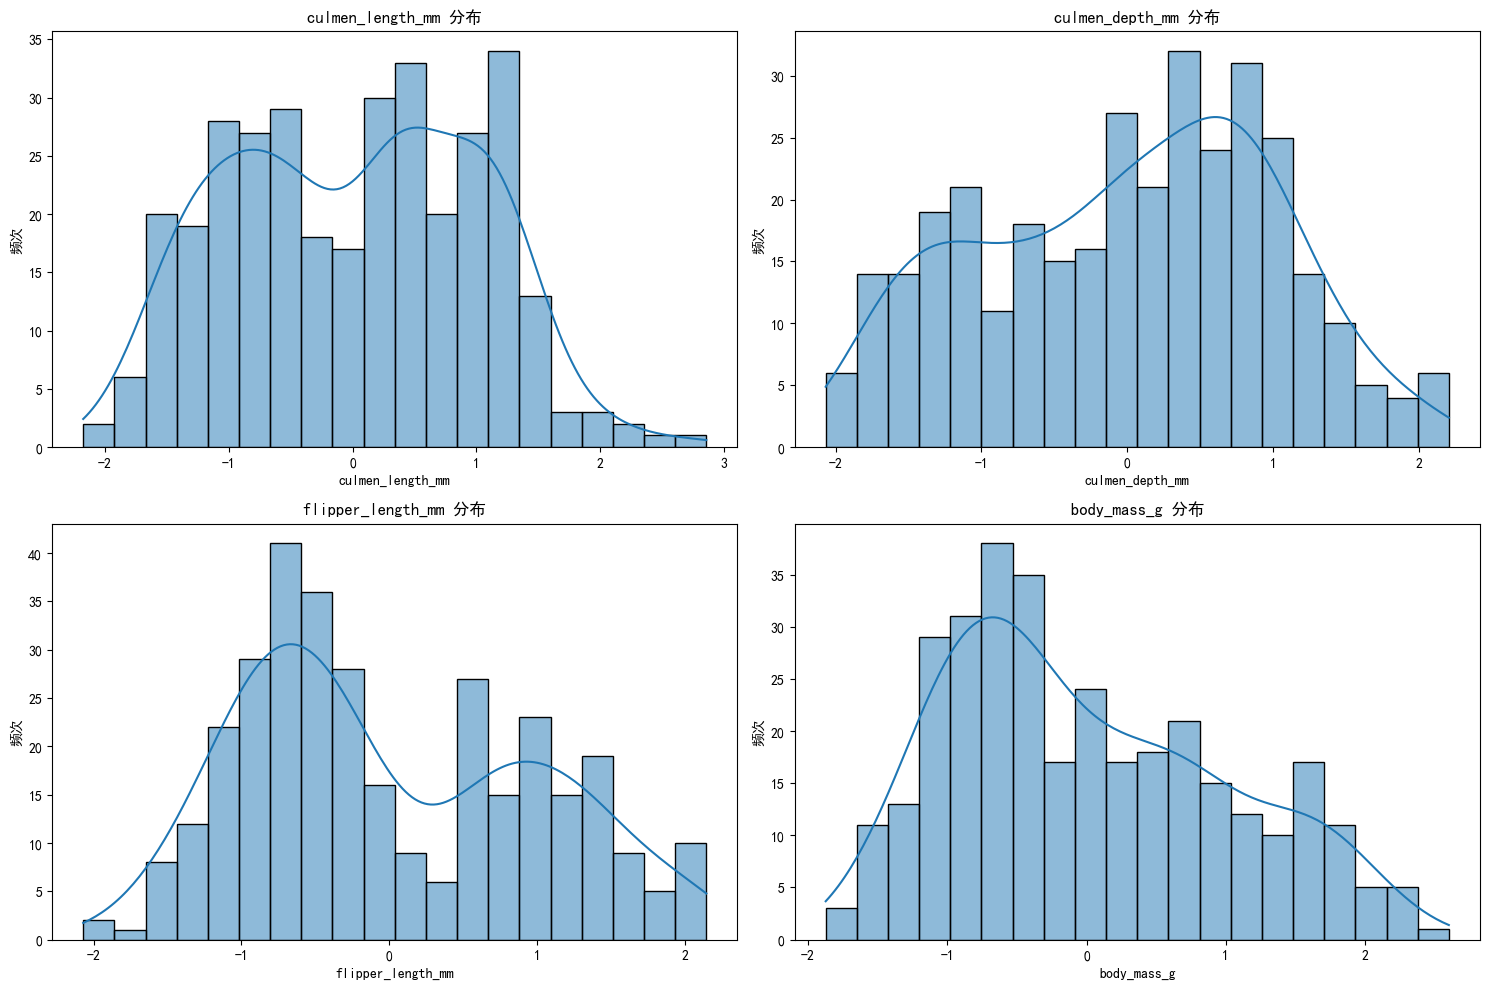

In [5]:
# 1.1 企鹅种类分布（带百分比标签）
plt.figure(figsize=(8, 5))
species_count = df_clean['species'].value_counts()
ax = sns.countplot(x='species', data=df_clean)
# 添加百分比标签
total = len(df_clean)
for p in ax.patches:
    percentage = f'{(p.get_height()/total)*100:.1f}%'
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+1, percentage, ha='center')
plt.title('企鹅种类分布')
plt.xlabel('种类')
plt.ylabel('数量')
plt.show()

# 1.2 岛屿分布（按种类拆分）
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='island', hue='species', data=df_clean)
plt.title('不同岛屿的企鹅种类分布')
plt.xlabel('岛屿')
plt.ylabel('数量')
plt.legend(title='种类')
# 计算每个种类在每个岛屿上的百分比
total = len(df_clean)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center")
plt.show()

# 1.3 数值特征分布（直方图+核密度图）
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:4]):  # 展示前4个核心数值特征
    plt.subplot(2, 2, i+1)
    sns.histplot(df_clean[col], kde=True, bins=20)
    plt.title(f'{col} 分布')
    plt.xlabel(col)
    plt.ylabel('频次')
plt.tight_layout()
plt.show()

## 双变量关联分析


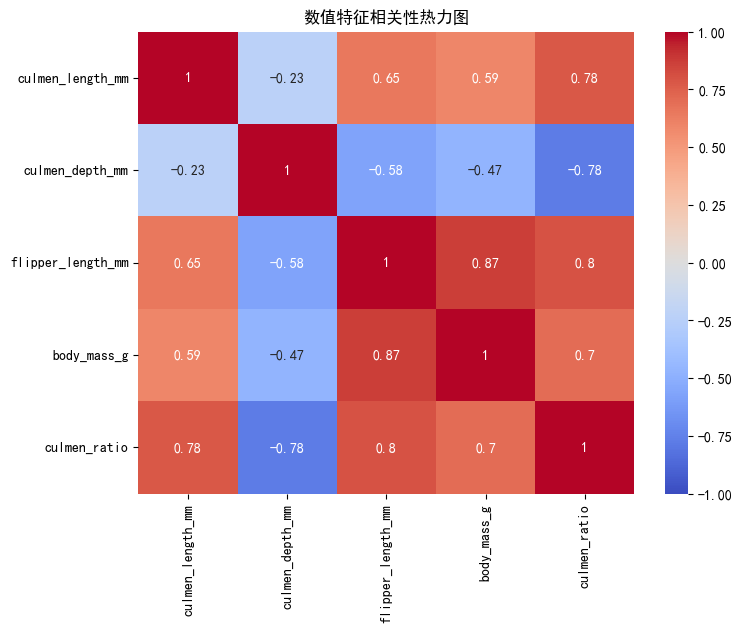

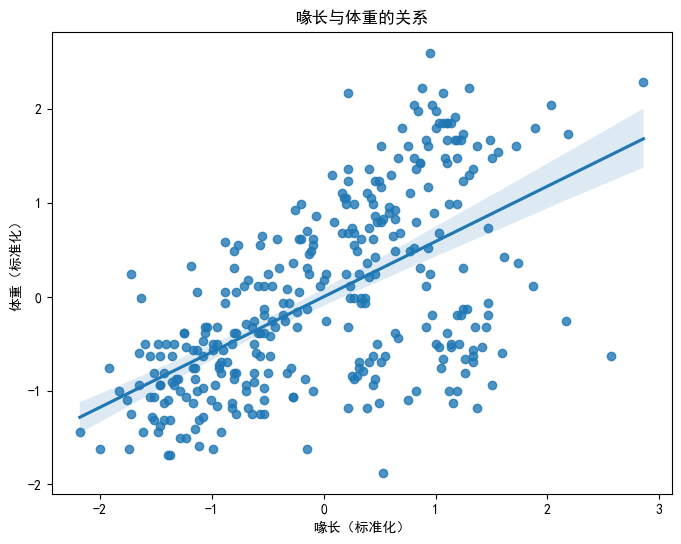

In [10]:
# 2.1 特征相关性热力图
plt.figure(figsize=(8, 6))
corr_matrix = df_clean[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('数值特征相关性热力图')
plt.show()

# 2.2 喙长vs体重
plt.figure(figsize=(8, 6))
sns.regplot(x='culmen_length_mm', y='body_mass_g', data=df_clean, scatter=True)
plt.title('喙长与体重的关系')
plt.xlabel('喙长（标准化）')
plt.ylabel('体重（标准化）')
plt.show()

## 多维度对比分析

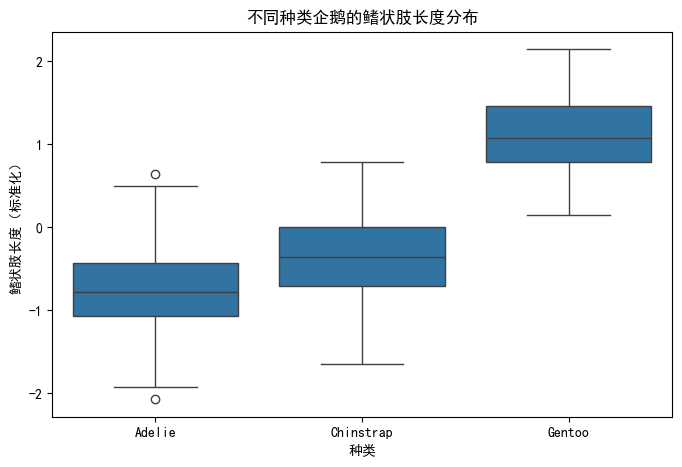

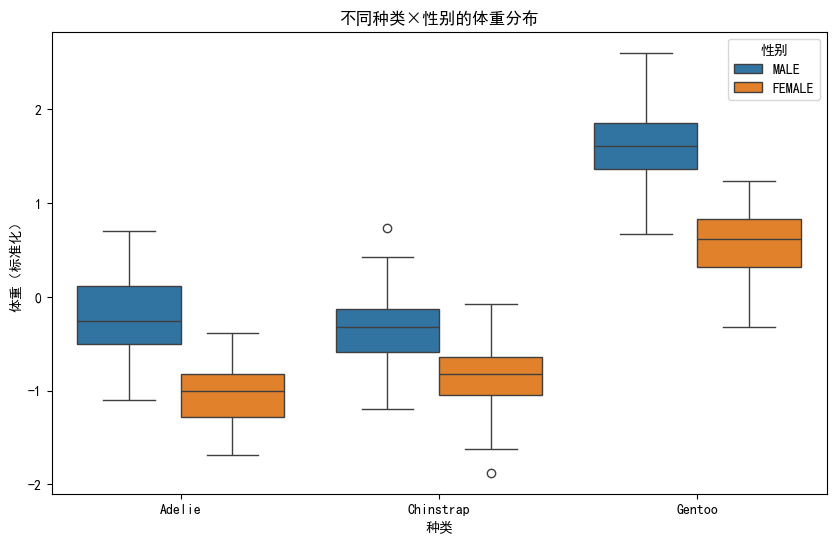

c:\Users\15638\anaconda3\envs\py\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


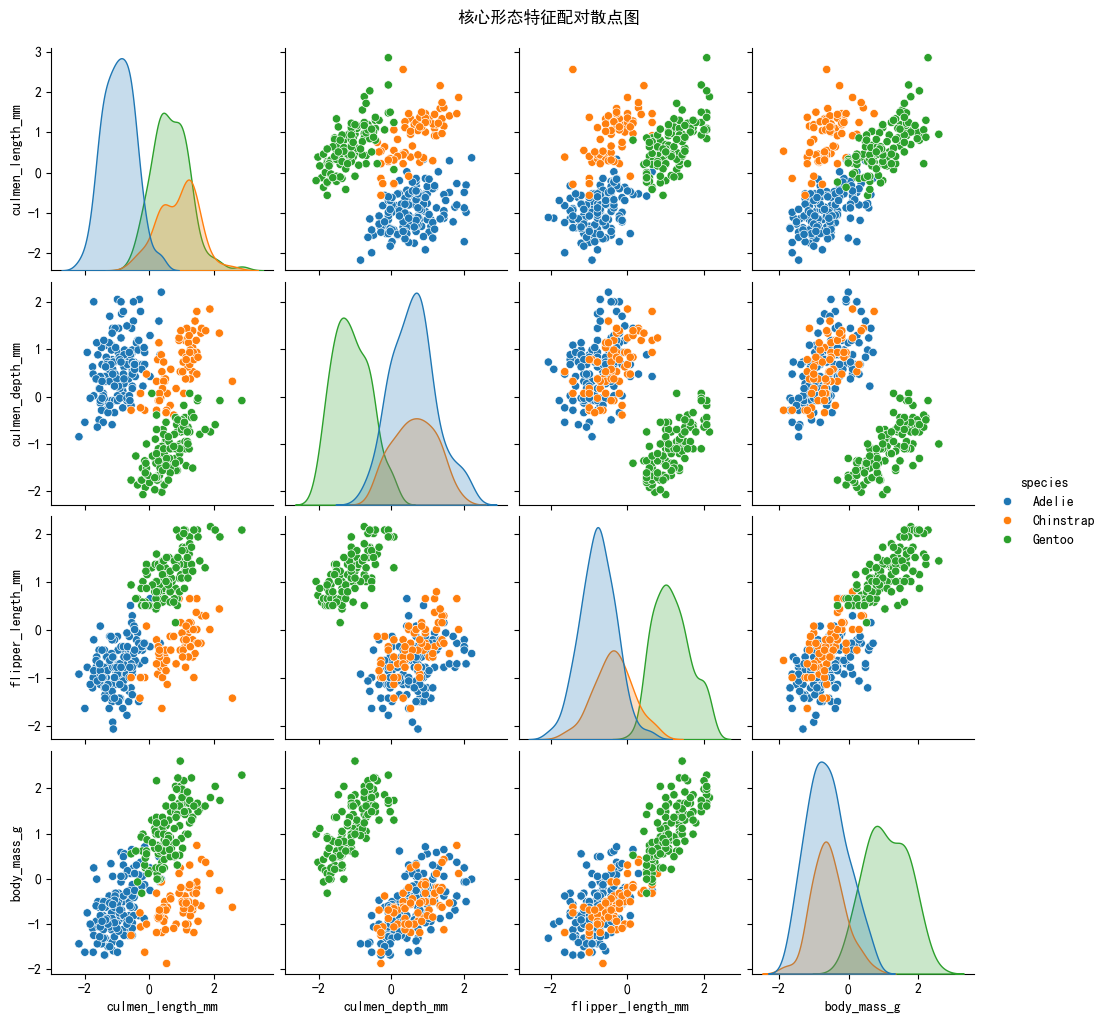

In [12]:
# 3.1 不同种类的鳍状肢长度对比（箱线图）
plt.figure(figsize=(8, 5))
sns.boxplot(x='species', y='flipper_length_mm', data=df_clean)
plt.title('不同种类企鹅的鳍状肢长度分布')
plt.xlabel('种类')
plt.ylabel('鳍状肢长度（标准化）')
plt.show()

# 3.2 不同性别×种类的体重对比
plt.figure(figsize=(10, 6))
sns.boxplot(x='species', y='body_mass_g', hue='sex', data=df_clean)
plt.title('不同种类×性别的体重分布')
plt.xlabel('种类')
plt.ylabel('体重（标准化）')
plt.legend(title='性别')
plt.show()

# 3.3 多特征配对散点图（按种类着色）
sns.pairplot(df_clean[numeric_cols[:4] + ['species']], hue='species', diag_kind='kde')
plt.suptitle('核心形态特征配对散点图', y=1.02)
plt.show()